# ML Term Paper - Code: Binary Models 
by Ann-Christin and Sarah 02/03/2021

## 1. Preparation

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.svm import l1_min_c
from time import time
from sklearn import linear_model

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


from sklearn import ensemble
from sklearn import tree as tree

# set color theme
sns.set_theme()

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
import os
# path = "E:\Data\krea\PIAAC" #enter your path here
path = "C:/Users/gust/Documents/ML_term_paper"
os.chdir(path)
print("done")
data = pd.read_csv("data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


C:\Users\gust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,4,11,17,22,24,25,28,30,31,38,47,50,57,58,59,62,63,65,68,75,84,85,86,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(230691, 129)

In [3]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0','inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 
                           'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",

# further exclude 
dcl = dcl.drop(columns = ['d_q16b', 'b_q20b', 'b_d12h', 'b_q02a_t2', 'b_q11', 'b_q12e', 'd_q12a' , 'b_q04a', 'b_q16', 'b_q26b', 'b_q15c', 'd_q06c', 'b_q15b', 'd_q05a2', 
                          'b_q13', 'b_q15a', 'b_q16', 'b_q02a', 'b_q02a_t1', 'b_q05c', 'b_q10b', 'c_d06', 'd_q04', 'b_q12g', 'b_q12b', 'b_q12d'])


dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [4]:
#dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')
dcl['gender_r'] = dcl['gender_r'].astype('category')
dcl["age_r"] = pd.to_numeric(dcl["age_r"])
dcl['b_q12a'] = dcl['b_q12a'].astype('category') # yes/no open educational training
#dcl['b_q12b'] = pd.to_numeric(dcl["b_q12b"]) # number of open/distance educational trainings
#dcl["b_q12d"] = pd.to_numeric(dcl["b_q12d"]) # number of on-the-job training
#dcl['b_q12e'] = dcl['b_q12e'].astype('category')  # yes/no seminars training
dcl['b_q12f'] = pd.to_numeric(dcl["b_q12f"]) # number of seminars
#dcl['b_q12g'] = dcl['b_q12g'].astype('category')  # yes/no private training
dcl['b_q12h'] = pd.to_numeric(dcl["b_q12h"]) # number of private educational trainings
# dcl['j_q03a'] = dcl['j_q03a'].astype('category') # yes/no children
dcl['j_q03b'] = pd.to_numeric(dcl['j_q03b']) # number of children
#dcl['yrsqual_t'] = pd.to_numeric(dcl['yrsqual_t'])
dcl['yrsget'] = pd.to_numeric(dcl['yrsget'])
dcl['iscoskil4'] = dcl['iscoskil4'].astype('category')
#dcl['h_q05g'] = dcl['h_q05g'].astype('category') # Skill use everyday life - ICT - Computer - How often - Programming language  
#dcl['g_q05g'] = dcl['g_q05g'].astype('category') # skill use work - ICT programming lanugage how often
#dcl['g_q05'] = dcl['g_q05'].astype('category') # use computer at work yes/no

In [5]:
cate = dcl.select_dtypes(include=['object', 'category'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['g_q05c',
 'gender_r',
 'd_q12b',
 'b_q14b',
 'd_q12c',
 'nopaidworkever',
 'g_q08',
 'f_q07a',
 'g_q07',
 'leaver1624',
 'g_q05a',
 'd_q06a',
 'pared',
 'g_q06',
 'g_q04',
 'g_q05e',
 'd_q06b',
 'b_q10a',
 'b_q12a',
 'c_q02a',
 'computerexperience',
 'f_q07b',
 'j_q04a',
 'g_q05f',
 'g_q05h',
 'cntryid',
 'd_q09',
 'edcat8',
 'g_q05g',
 'isic1c',
 'd_q03',
 'd_q07a',
 'd_q14',
 'b_q26a_t',
 'b_q12c',
 'b_q14a',
 'vet',
 'b_q10c',
 'g_q05d',
 'd_q13c',
 'b_q01b',
 'd_q04_t']

In [6]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,g_q05c_Every day,g_q05c_Less than once a month,g_q05c_Less than once a week but at least once a month,g_q05c_Never,gender_r_Male,d_q12b_A lower level would be sufficient,d_q12b_This level is necessary,b_q14b_Other,b_q14b_To be less likely to lose my job,b_q14b_To do my job better and/or improve career prospects,...,b_q01b_Health and welfare,"b_q01b_Humanities, languages and arts","b_q01b_Science, mathematics and computing",b_q01b_Services,"b_q01b_Social sciences, business and law",b_q01b_Teacher training and education science,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people","d_q04_t_Self-employed, not supervisor","d_q04_t_Self-employed, supervisor"
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
230687,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
230688,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
230689,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies.head()
dummies.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 182 entries, g_q05c_Every day to skill_3
dtypes: uint8(182)
memory usage: 40.0 MB


In [8]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [9]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   readytolearn   226734 non-null  float64
 6   earnmthallppp  88508 non-null   float64
dtypes: float64(7)
memory usage: 12.3 MB


In [10]:
num_list = list(set(num))
num_list

['c_q10a',
 'c_q09',
 'age_r',
 'readytolearn',
 'earnmthallppp',
 'j_q03b',
 'yrsget']

In [11]:
# define X and y
on_job = dummies["b_q12c_Yes"] #define y here
open_educ = dummies["b_q12a_Yes"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
X = X.drop(columns = ["b_q12c_Yes", "b_q12a_Yes"])
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05c_Every day,...,b_q01b_Services,"b_q01b_Social sciences, business and law",b_q01b_Teacher training and education science,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people","d_q04_t_Self-employed, not supervisor","d_q04_t_Self-employed, supervisor",skill_1,skill_2,skill_3
0,0,0,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,NaN,NaN,19.0,NaN,NaN,2.164922,NaN,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,1,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,NaN,NaN,8.0,NaN,NaN,1.177736,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
230687,0,0,NaN,NaN,11.0,NaN,NaN,2.156445,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230688,1,0,NaN,NaN,11.0,NaN,NaN,2.383062,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
230689,0,0,NaN,NaN,12.0,NaN,NaN,1.751830,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 2. Logit

### 2.1 Logit 'on_job'

In [12]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]


In [13]:
X

,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05c_Every day,g_q05c_Less than once a month,g_q05c_Less than once a week but at least once a month,...,"b_q01b_Humanities, languages and arts","b_q01b_Science, mathematics and computing",b_q01b_Services,"b_q01b_Social sciences, business and law",b_q01b_Teacher training and education science,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people",skill_1,skill_2,skill_3
18418,33.0,2.0,11.0,6.0,1.0,2.361800,2500.0000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
18423,43.0,1.0,11.0,24.0,1.0,1.124230,1343.1400,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18433,53.0,2.0,9.0,27.0,2.0,0.788280,980.3900,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18434,42.0,1.0,11.0,18.0,1.0,1.470600,1314.2200,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18439,50.0,1.0,11.0,29.0,1.0,0.664940,1460.7800,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225548,43.0,2.0,15.0,23.0,1.0,1.239026,6153.8480,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
225552,42.0,2.0,12.0,22.0,1.0,1.177736,3509.6165,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
225554,24.0,1.0,12.0,6.0,15.0,2.004488,2500.0007,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
225555,51.0,3.0,8.0,35.0,2.0,1.002733,929.0080,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                            Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                         inf   
Dependent Variable:                          on_job                                   AIC:                                      inf   
Date:                                        2021-03-03 14:06                         BIC:                                      inf   
No. Observations:                            40950                                    Log-Likelihood:                           -inf  
Df Model:                                    160                                      LL-Null:                                  0.0000
Df Residuals:                                40789                                    LLR p-value:                              1.0000
Converged:                                   1.0000                                   Scale:                       

## 2.2 Logit 'off job'

In [15]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]


In [16]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                            Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                         inf   
Dependent Variable:                          open_educ                                AIC:                                      inf   
Date:                                        2021-03-03 14:06                         BIC:                                      inf   
No. Observations:                            40950                                    Log-Likelihood:                           -inf  
Df Model:                                    160                                      LL-Null:                                  0.0000
Df Residuals:                                40789                                    LLR p-value:                              1.0000
Converged:                                   1.0000                                   Scale:                       

## 3. Logit with Penalty

## 3.1. 'on job training'

In [17]:
nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [18]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [19]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')


C: 10
Coefficient of each feature: [[-1.29425952e-02  1.37841386e-02 -6.79195474e-04  9.80722075e-03
   7.01625933e-03 -3.63634927e-04 -3.03757261e-07 -1.12205170e-01
  -2.89793348e-01  9.12112140e-02 -8.16915967e-03  1.27610758e-01
   2.60585527e-02 -3.08881735e-02  3.67423450e+00  4.33748348e+00
   4.19096674e+00  3.97526857e+00  3.73424267e+00  4.31703557e+00
   4.00087520e+00 -1.03363266e-03  2.54384645e-02 -9.70713783e-03
  -1.29147392e-01  7.21175388e-02 -1.34925045e-01 -3.63770512e-02
  -2.92165714e-02 -5.48980990e-01  6.24184335e-02 -3.72774383e-02
  -6.19950854e-02 -1.37780324e-01  3.17519711e-01  6.24321368e-01
   5.24689666e-01  6.79994496e-01 -1.30253517e-02 -8.29459260e-02
   1.10920014e-01  1.68669441e-01  5.15245334e-01 -2.44672702e-02
   4.95226143e-02  8.05407946e-02 -4.71170812e-02 -8.30605772e-02
  -1.74125697e-01  2.18300399e-01 -4.11152685e-03  1.33825700e-01
   2.94668638e-02  7.21744305e-02 -2.28853490e-01  2.03138347e-03
  -1.37544746e-01 -3.79531123e-03  1.1494

Computing regularization path ...
This took 76.912s


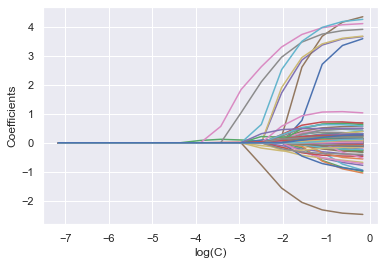

In [20]:
# regularization path

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_on_job.png', bbox_inches='tight')
plt.show()

In [21]:
clf = LogisticRegression(penalty='l1', C=10, solver='liblinear')
logit = clf.fit(X_train, y_train)


y_pred=logit.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[6646,  662],
       [1305, 3672]], dtype=int64)

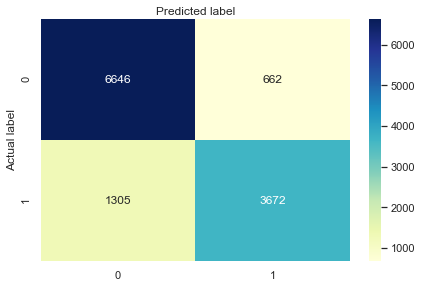

In [22]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\confusion_on_job.png', bbox_inches='tight')

In [23]:
print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
print('') 


Coefficient of each feature: [[-1.48540066e-02  1.16698436e-02 -7.05802143e-03  1.09267293e-02
   4.76870680e-03 -5.52058438e-03 -2.95724341e-07 -1.10089676e-01
  -2.89213398e-01  9.13138166e-02 -7.63180308e-03  1.23252775e-01
   2.51660792e-02 -3.11339904e-02  3.66989221e+00  4.33261600e+00
   4.18900997e+00  3.97414672e+00  3.72467717e+00  4.31101780e+00
   3.98347780e+00 -1.32292024e-02  2.29472440e-02 -1.85069415e-02
  -1.48402137e-01  5.55915002e-02 -1.35286733e-01 -5.19585711e-02
  -2.52142408e-02 -5.88322533e-01  6.61132710e-02 -3.49792783e-02
  -5.79939542e-02 -1.36183162e-01  3.08991112e-01  6.15633034e-01
   5.16190754e-01  6.72531522e-01 -1.98345343e-02 -8.84132504e-02
   1.12173486e-01  1.68879483e-01  4.75405696e-01 -2.14608566e-02
   5.19738125e-02  8.31076998e-02 -4.32664145e-02 -8.97882015e-02
  -1.82816964e-01  2.11582712e-01 -3.60489376e-02  1.27639745e-01
   9.83679978e-04  7.18965617e-02 -2.25023002e-01  2.16042523e-03
  -1.39505478e-01  7.50667391e-04  1.20697700e-

In [24]:
imp = pd.DataFrame(clf.coef_).T
imp['Feature'] = list(X_train.columns)
print(imp)

            0                                            Feature
0   -0.014854                                              age_r
1    0.011670                                             j_q03b
2   -0.007058                                             yrsget
3    0.010927                                              c_q09
4    0.004769                                             c_q10a
..        ...                                                ...
156 -0.022840  d_q04_t_Employee, supervising fewer than 5 people
157  0.184175   d_q04_t_Employee, supervising more than 5 people
158  0.125499                                            skill_1
159  0.121613                                            skill_2
160  0.229404                                            skill_3

[161 rows x 2 columns]


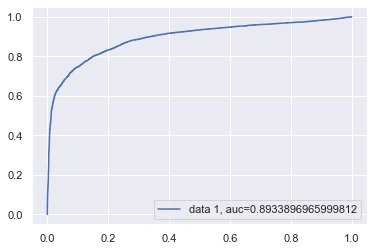

In [25]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_on_job.png', bbox_inches='tight')
plt.show()

### 3.2 open education

In [26]:
nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [27]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [28]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')


C: 10
Coefficient of each feature: [[-1.01472470e-02 -6.12445743e-03  2.37244088e-02  1.01657520e-02
   2.61300129e-03  5.73517616e-02  4.05280414e-09  4.15431816e-02
  -7.44112752e-02 -1.05183609e-01 -1.71962654e-01 -4.03297242e-02
  -8.16629926e-02 -1.58711326e-01  1.05102814e+00  1.12489728e+00
   1.16106912e+00  1.04904233e+00  1.66285384e+00  1.69288996e+00
   1.38009225e+00  2.12045409e-02 -5.63489256e-02 -4.94219104e-02
  -2.07680379e-01  1.34632734e-01 -1.45016398e-01  5.23984359e-02
   1.78008042e-01 -5.94736530e-01  4.24860894e-02  0.00000000e+00
   1.63872779e-01  1.50129110e-02  1.10332125e-01  2.31189147e-01
   1.91931448e-01  2.56308997e-01 -1.09634596e-01 -3.44011062e-02
   6.24702563e-02 -2.67453014e-03  3.33662880e-01  1.29833352e-01
   9.40703953e-02  8.48531392e-02  1.20504064e-01  7.92673996e-03
   3.19346896e-02  7.30156204e-01  4.03264994e-01  1.34105839e-01
  -1.69118897e-01  6.11659318e-02  2.56795229e-02 -8.36675956e-02
   0.00000000e+00  1.01636182e-02 -5.4553

Computing regularization path ...
This took 46.708s


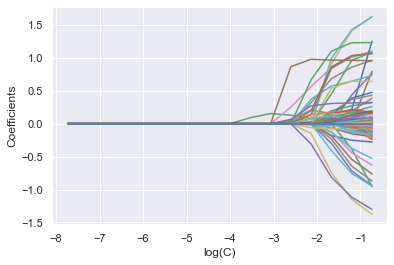

In [29]:
# regularization path (takes a lot of time)

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_open_educ.png', bbox_inches='tight')
plt.show()

In [30]:
clf = LogisticRegression(penalty='l1', C=10, solver='liblinear')
logit = clf.fit(X_train, y_train)


y_pred=logit.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10838,   159],
       [ 1056,   232]], dtype=int64)

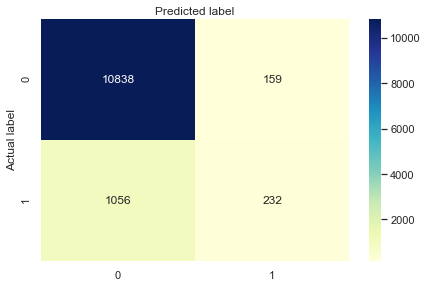

In [31]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\confusion_open_educ.png', bbox_inches='tight')

In [32]:
print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
print('') 



Coefficient of each feature: [[-1.07797802e-02 -6.19797047e-03  2.25406597e-02  1.06012201e-02
   2.07091262e-03  5.64896159e-02  4.32604958e-09  4.16737178e-02
  -7.51171800e-02 -1.05281953e-01 -1.72522437e-01 -4.13662372e-02
  -8.19528540e-02 -1.59249457e-01  1.04952809e+00  1.12312396e+00
   1.15968532e+00  1.04796087e+00  1.66046623e+00  1.69064535e+00
   1.37562796e+00  1.93460408e-02 -5.62425416e-02 -5.12214029e-02
  -2.10428818e-01  1.32315455e-01 -1.44888066e-01  4.95316081e-02
   1.77578549e-01 -6.04405784e-01  4.13525639e-02  0.00000000e+00
   1.63305975e-01  1.42522994e-02  1.08786060e-01  2.29377728e-01
   1.90329330e-01  2.54708544e-01 -1.10639137e-01 -3.54571700e-02
   6.18674738e-02 -3.14758925e-03  3.37719336e-01  1.29872417e-01
   9.39586357e-02  8.48594035e-02  1.20737026e-01  6.88608095e-03
   3.04652301e-02  7.28451471e-01  3.90999732e-01  1.33368127e-01
  -1.74460187e-01  6.09909736e-02  2.55256542e-02 -8.39363702e-02
   0.00000000e+00  9.30468776e-03 -5.52353380e-

In [33]:
imp = pd.DataFrame(clf.coef_).T
imp['Feature'] = list(X_train.columns)
print(imp)

            0                                            Feature
0   -0.010780                                              age_r
1   -0.006198                                             j_q03b
2    0.022541                                             yrsget
3    0.010601                                              c_q09
4    0.002071                                             c_q10a
..        ...                                                ...
156  0.003254  d_q04_t_Employee, supervising fewer than 5 people
157  0.030141   d_q04_t_Employee, supervising more than 5 people
158  0.008721                                            skill_1
159  0.019694                                            skill_2
160 -0.022302                                            skill_3

[161 rows x 2 columns]


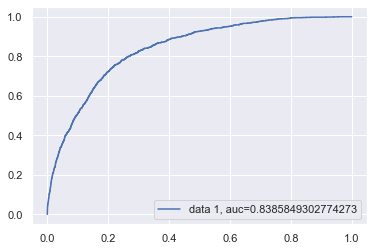

In [34]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_open_educ.png', bbox_inches='tight')
plt.show()